# <font color="#114b98">Conception d'une application au service de la santé publique</font>

## <font color="#114b98">II - Notebook d'analyse</font>

Afin de répondre aux **enjeux climatiques et démographiques** des années à venir, "Santé Publique France" souhaite concevoir une application proposant des **alternatives à la consommation de viandes animales et de poissons**.

Après avoir scanné le code produit d'un article, cette application vous propose une série de produits alimentaires qui vous apporteront **une quantité similaire de substrats énergétiques**. 

Je vais dans ce second notebook **réaliser des analyses univariées, bivariées et multivariées**, ainsi que des **réductions dimentionnelles**.

## <font color="#114b98">Sommaire</font>
[1. Chargement du dataset](#section_1)

[2. Analyse univariée](#section_2)

[3. Analyse bivariée](#section_3)       

[4. Analyse multivariée](#section_4)      

[5. Réduction dimentionnelle](#section_5)

[6. Exemple d'association pour l'application](#section_6)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [2]:
sns.set()

In [3]:
df = pd.read_csv('../1 - Projets/Projet 2/fr.openfoodfacts.org.products_cleaned.csv', low_memory=False)
df.drop('Unnamed: 0', inplace=True, axis=1)

In [4]:
data = df.copy()

## <font color="#114b98" id="section_5">5. Réduction dimentionnelle</font>

Pour cette réduction du nombre de dimensions, je vais réaliser une Analyse en Composantes Principale (PCA).

Pour cela, j'utilise la méthode PCA du module decomposition de sklearn sur les variables numériques centrées et réduites. 

Je prendrais en variable illustrative de cette ACP la variable 'régime'.

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#Centrage et réduction
X = data.select_dtypes(include=['float64'])
features = X.columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Instanciation de l'ACP
pca = PCA(svd_solver='full').fit(X_scaled)
X_projected = pca.transform(X_scaled)

Afin d'avoir un aperçu du nombre de composantes nécessaire à l'analyse, je vais projeter l'éboulis des valeurs propres :

In [6]:
pca.explained_variance_ratio_

array([0.27384717, 0.22024126, 0.13193391, 0.11709328, 0.10495645,
       0.07519985, 0.04382113, 0.02704526, 0.00586169])

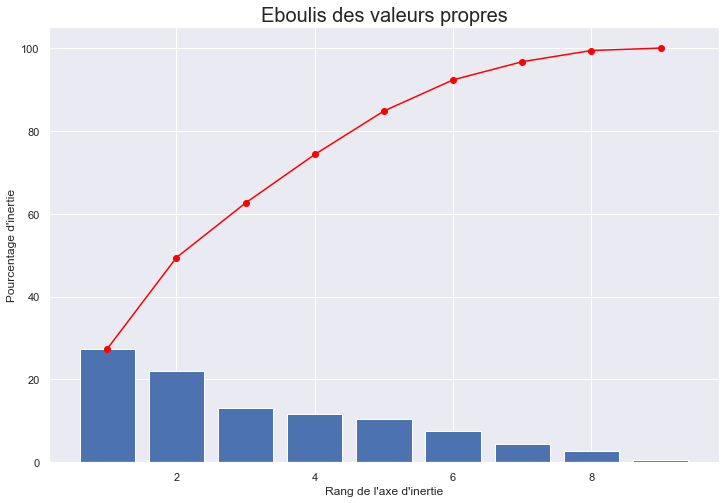

In [7]:
#Variances expliquées
varexpl = pca.explained_variance_ratio_*100

#Projection de l'éboulis des valeurs propres
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)
plt.plot(np.arange(len(varexpl))+1, varexpl.cumsum(),c="red",marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres", size = 20)
plt.show(block=False)

In [8]:
print("Le premier plan factoriel couvrira une inertie de {:.2f}% et le second plan : {:.2f}%.".
      format(varexpl[0:2].sum(),
             varexpl[0:4].sum()))

Le premier plan factoriel couvrira une inertie de 49.41% et le second plan : 74.31%.


Les 2 premiers plans factoriels couvrent une inertie d'un peu plus de 74%.

Je projette à présent le cercle des corrélations :

In [9]:
#Espace des composantes principales
pcs = pca.components_

pcs2 = pd.DataFrame(pcs)
pcs2.columns = features
x_list = range(1, len(features)+1)
pcs2.index = [f"F{i}" for i in x_list]

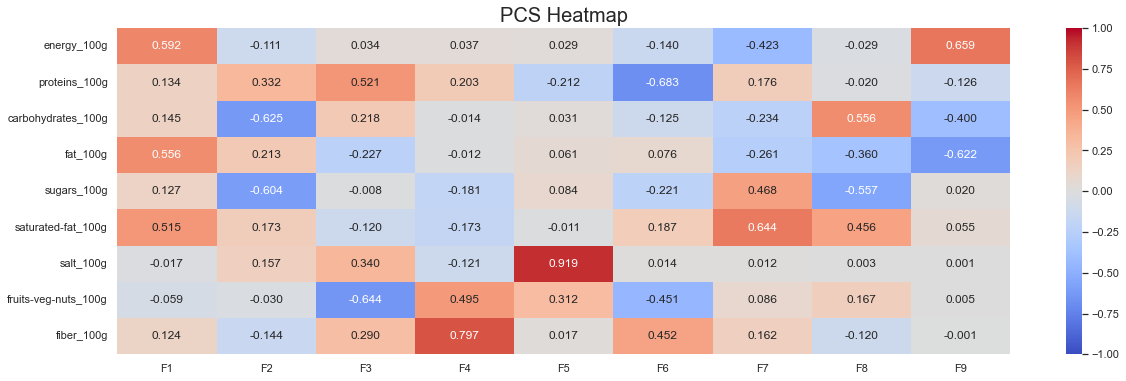

In [10]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.title("PCS Heatmap", size = 20)
sns.heatmap(pcs2.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.3f");

In [11]:
#Variable Illustrative
iv = data['régime'].values

#Encodage des grades
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
iv = encoder.fit_transform(iv)
iv = iv.reshape((iv.shape[0],1))

#Corrélation de la variable illustrative avec les axes factoriels 
corrIv = np.zeros((iv.shape[1],X.shape[1]))
for j in range(X.shape[1]): 
    for k in range(iv.shape[1]): 
        corrIv[k,j] = np.corrcoef(iv[:,k],X_projected[:,j])[0,1]

In [12]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.05,
                head_length=0.05, 
                width=0.01, )
        illustrative_var_label='régime'
        
        for d1,d2 in [(0,1),(2,3)]:
            if d2 < 2:   
                if illustrative_var_label is not None :
                    plt.annotate('régime',(corrIv[0,x]-0.1,corrIv[0,y]+0.05), color='red')
                    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),corrIv[0,x],corrIv[0,y], angles='xy', 
                               scale_units='xy', scale=1, color="red", alpha=0.5, width=0.005)
        # Les labels
        plt.text(pca.components_[x, i] + 0.10,
                pca.components_[y, i] + 0,
                features[i])
    
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1), size = 20)

    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))
    plt.axis('equal')
    plt.show(block=False)

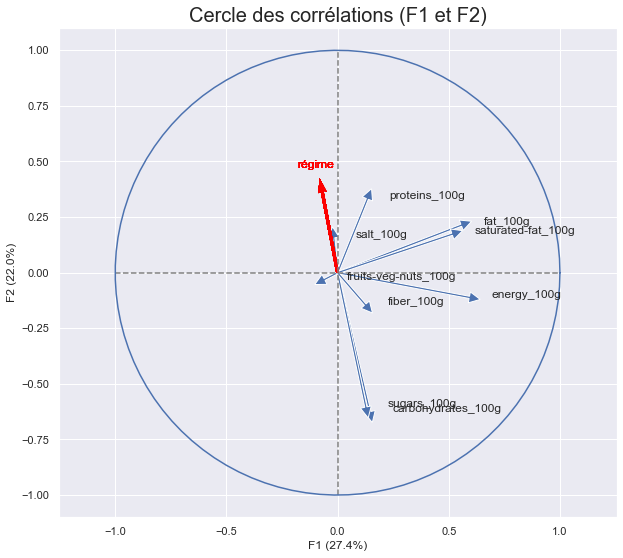

In [13]:
correlation_graph(pca, (0,1), features)

L'axe F1 semble représenter le facteur "énergétique" et l'axe F2 quant à lui les qualités "sucré / salé" des produits.

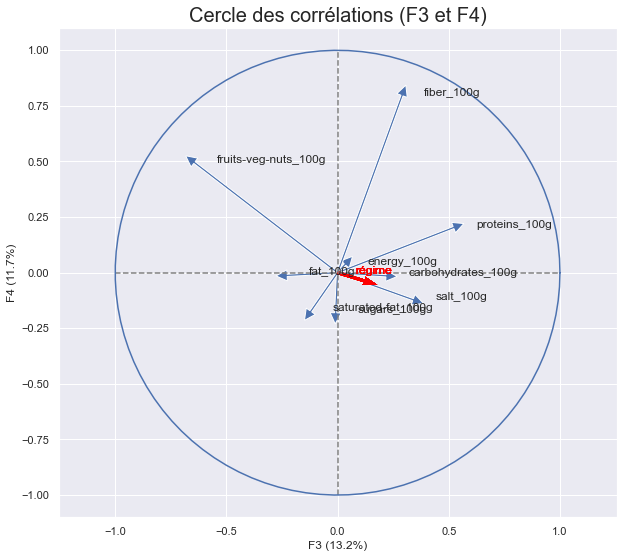

In [14]:
correlation_graph(pca, (2,3), features)

L'axe F3 semble représenter le facteur "fruits/légumes/fibres" et l'axe F4 quant à lui les qualités "gras / non-gras" des produits.

On peut à présent visualiser la projection des individus sur ces premiers plans factoriels et donc en 2D :

In [15]:
def plot_plans_factoriels(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=0.4, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,8))
        
            # affichage des points
            
            
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha, s=15)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, s=15)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
            
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des {} individus sur F{} et F{}".format(X_projected.shape[0], d1+1, d2+1), size = 20)
            plt.show(block=False)

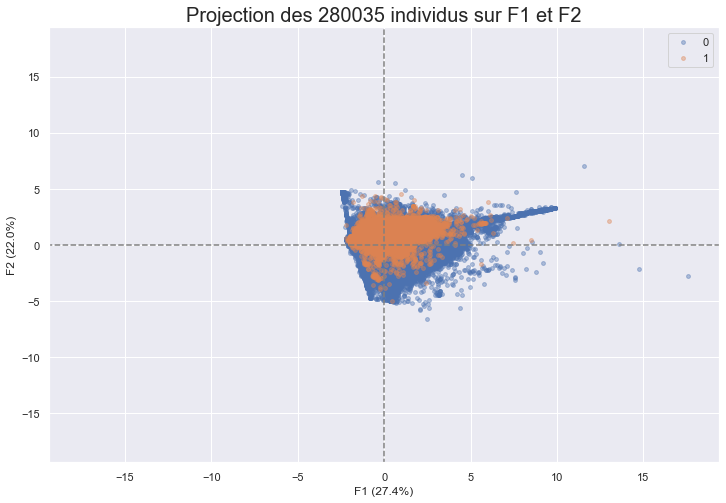

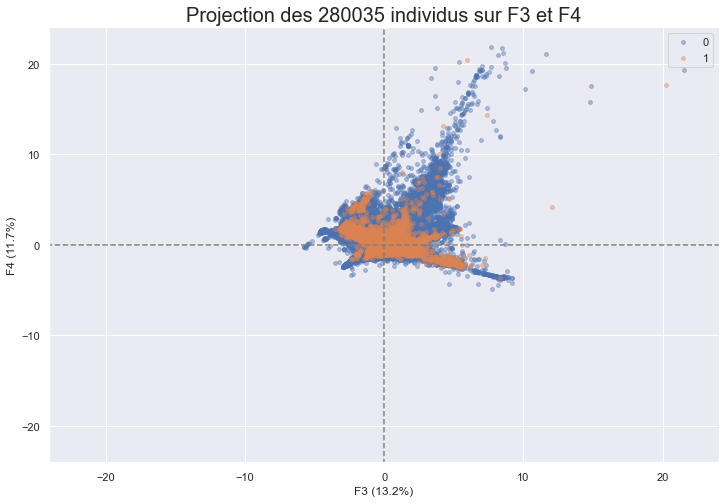

In [16]:
plot_plans_factoriels(X_projected, 4, pca, [(0,1),(2,3)], illustrative_var = iv)

Les produits avec viandes ou poissons sont bien intégrés avec les autre produits (formes des projections similaires).

Afin d'analyser la performance de notre réduction de dimension via PCA, je vais regarder le COS² et la CTR*.

On peut calculer la qualité de représentation des variables (COS²) en élevant la corrélation au carré :

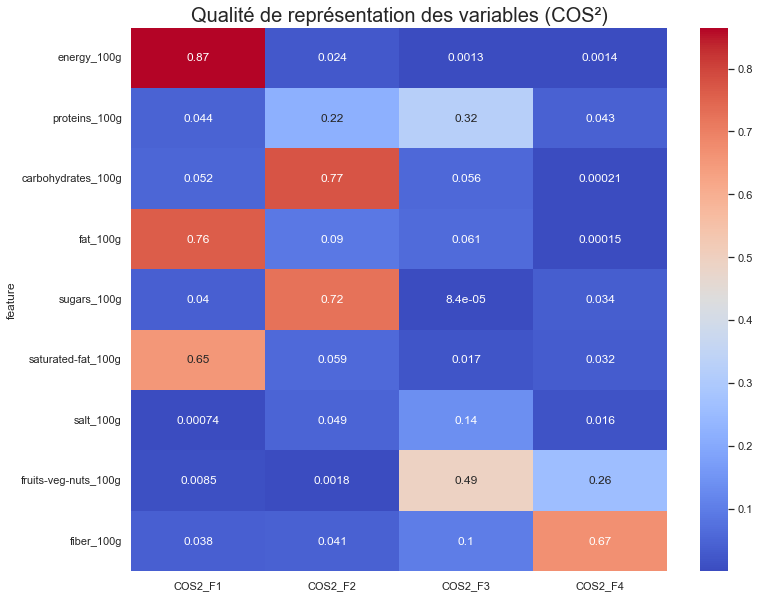

In [17]:
sqrt_valprop = np.sqrt(pca.explained_variance_)
corvar = np.zeros((X.shape[1], X.shape[1]))
for dim in range(X.shape[1]):
    corvar[:,dim] = pcs[dim,:] * sqrt_valprop[dim]

# Calcul des COS²
cos2var = corvar**2
df_cos2var = pd.DataFrame({'feature':X.columns,'COS2_F1':cos2var[:,0],
                           'COS2_F2':cos2var[:,1], 'COS2_F3':cos2var[:,2],
                           'COS2_F4':cos2var[:,3]}).set_index('feature')

# Affichage dans un heatmap seaborn
fig = plt.figure(figsize=(12,10))
sns.heatmap(df_cos2var, annot=True, cmap="coolwarm")
plt.title("Qualité de représentation des variables (COS²)", size = 20)
plt.show()

Je remarque ici, avec le cercle et le COS², les corrélations importantes entre l'energie et le caractère "gras" des produits. 

Je regarde à présent la contribution des variables aux axes (CTR), elle aussi également basée sur le carré de la corrélation, mais relativisée par l’importance de l’axe :

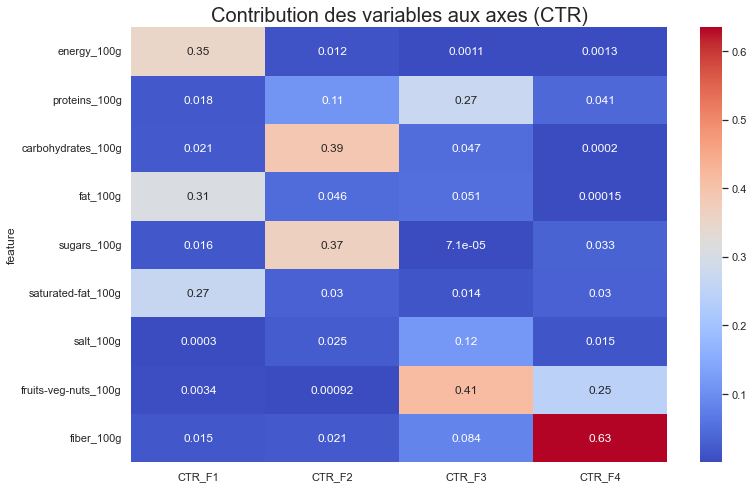

In [18]:
# Contributions 
ctrvar = cos2var 
for k in range(X.shape[1]): 
    ctrvar[:,k] = ctrvar[:,k]/pca.explained_variance_[k] 

df_ctrvar = pd.DataFrame({'feature':X.columns,'CTR_F1':ctrvar[:,0],'CTR_F2':ctrvar[:,1],
                         'CTR_F3':ctrvar[:,2], 'CTR_F4':ctrvar[:,3]}).set_index('feature')

#affichage dans un heatmap seaborn
fig = plt.figure(figsize=(12,8))
sns.heatmap(df_ctrvar, annot=True, cmap="coolwarm")
plt.title("Contribution des variables aux axes (CTR)",size = 20)
plt.show()

Je réalise à présent une PCA 3D avec 3 composantes principales.

In [19]:
#Centrage et réduction
df_distrib_av = data.copy()
X = df_distrib_av.select_dtypes(include=['float64'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
pca = PCA(svd_solver='full', n_components=3).fit(X_scaled)
X_projected = pca.transform(X_scaled)

In [21]:
# total_var = pca.explained_variance_ratio_.sum() * 100

# fig = px.scatter_3d(
#     X_projected, x=0, y=1, z=2, color=df_distrib_av['régime'],
#     title=f'Variance expliquée totale : {total_var:.2f}%',
#     labels={'0': 'F1', '1': 'F2', '2': 'F3'})
# fig.update_traces(marker_size = 3)
# fig.show()

In [22]:
# total_var = pca.explained_variance_ratio_.sum() * 100

# fig = px.scatter_3d(
#     X_projected, x=0, y=1, z=2, color=df_distrib_av['nutriscore'],
#     title=f'Variance expliquée totale : {total_var:.2f}%',
#     labels={'0': 'F1', '1': 'F2', '2': 'F3'})
# fig.update_traces(marker_size = 3)
# fig.show()

Je peux aussi faire une réduction dimentionnelle à l'aide de UMAP.

UMAP est un algorithme de réduction de dimension basé sur de multiples techniques d'apprentissage issues de l'analyse de données topologiques.

In [23]:
#pip install umap-learn

In [24]:
import umap.umap_ as umap

In [25]:
X = df_distrib_av.select_dtypes(include=['float64'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = df_distrib_av['régime']

In [26]:
reducer = umap.UMAP()

In [27]:
embedding = reducer.fit_transform(X_scaled)
embedding.shape

(280035, 2)

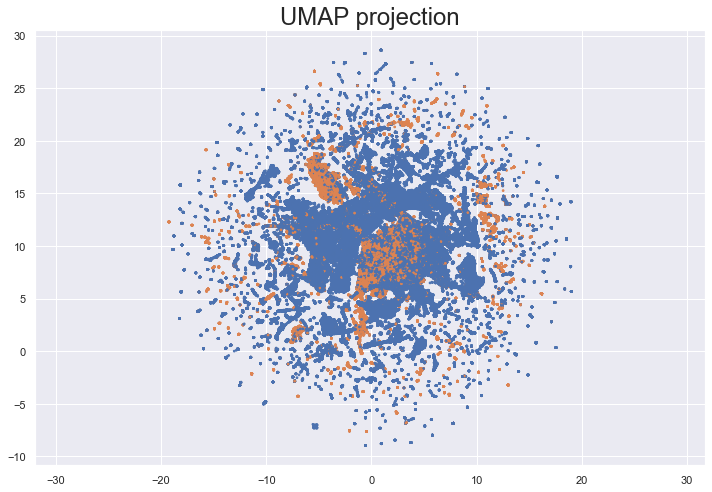

In [28]:
fig = plt.figure(figsize=(12,8))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in y.map({"viandes_poissons":1, "autres_produits":0})],
    s = 3)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24);

Une autre méthode de réduction de dimension est t-SNE (t-distributed Stochastic Neighbor Embedding).

Cette méthode est utilisée principalement pour la visualisation de données dans des cartes 2D et 3D.

In [29]:
from sklearn.manifold import TSNE

In [30]:
X = df_distrib_av.select_dtypes(include=['float64'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = df_distrib_av['régime']

In [31]:
tsne = TSNE(n_components=2, verbose=1, random_state=99, learning_rate='auto', init='random', perplexity=10)
z = tsne.fit_transform(X_scaled) 

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 280035 samples in 0.720s...
[t-SNE] Computed neighbors for 280035 samples in 27.433s...
[t-SNE] Computed conditional probabilities for sample 1000 / 280035
[t-SNE] Computed conditional probabilities for sample 2000 / 280035
[t-SNE] Computed conditional probabilities for sample 3000 / 280035
[t-SNE] Computed conditional probabilities for sample 4000 / 280035
[t-SNE] Computed conditional probabilities for sample 5000 / 280035
[t-SNE] Computed conditional probabilities for sample 6000 / 280035
[t-SNE] Computed conditional probabilities for sample 7000 / 280035
[t-SNE] Computed conditional probabilities for sample 8000 / 280035
[t-SNE] Computed conditional probabilities for sample 9000 / 280035
[t-SNE] Computed conditional probabilities for sample 10000 / 280035
[t-SNE] Computed conditional probabilities for sample 11000 / 280035
[t-SNE] Computed conditional probabilities for sample 12000 / 280035
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 147000 / 280035
[t-SNE] Computed conditional probabilities for sample 148000 / 280035
[t-SNE] Computed conditional probabilities for sample 149000 / 280035
[t-SNE] Computed conditional probabilities for sample 150000 / 280035
[t-SNE] Computed conditional probabilities for sample 151000 / 280035
[t-SNE] Computed conditional probabilities for sample 152000 / 280035
[t-SNE] Computed conditional probabilities for sample 153000 / 280035
[t-SNE] Computed conditional probabilities for sample 154000 / 280035
[t-SNE] Computed conditional probabilities for sample 155000 / 280035
[t-SNE] Computed conditional probabilities for sample 156000 / 280035
[t-SNE] Computed conditional probabilities for sample 157000 / 280035
[t-SNE] Computed conditional probabilities for sample 158000 / 280035
[t-SNE] Computed conditional probabilities for sample 159000 / 280035
[t-SNE] Computed conditional probabilities for sample 160000 / 280035
[t-SNE] Computed con

[t-SNE] KL divergence after 250 iterations with early exaggeration: 117.164642
[t-SNE] KL divergence after 1000 iterations: 3.120796


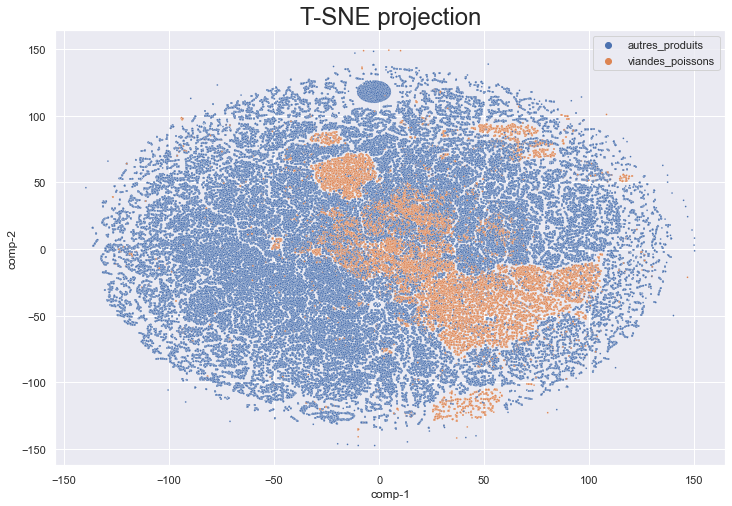

In [32]:
df = pd.DataFrame()
df["régime"] = y
df["comp-1"] = z[:,1]
df["comp-2"] = z[:,0]

fig = plt.figure(figsize=(12,8))
plt.title('T-SNE projection', fontsize=24)

sns.scatterplot(x="comp-1", y="comp-2", hue=y.tolist(), s=3, 
                c=[sns.color_palette()[x] for x in y.map({"viandes_poissons":1, "autres_produits":0})],
                data=df);

Je remarque des similarités dans les projection réalisées avec UMAP et t-SNE.

## <font color="#114b98" id="section_6">6. Exemple d'association pour l'application</font>

Je vais prendre au hasard un produit issu du jeu de données, appartenant à la catégorie 'viandes_poissons' de la variable 'régime', comme si il avait été scanné dans un magasin.

In [33]:
data_s = data[:]

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [35]:
idx = data_s[data_s['régime']=='viandes_poissons'].sample(1).index

In [36]:
data_s.iloc[idx,1]

121215    Nems au porc
Name: categories, dtype: object

In [37]:
y = data_s.iloc[idx,2:11]

In [38]:
y

,energy_100g,proteins_100g,carbohydrates_100g,fat_100g,sugars_100g,saturated-fat_100g,salt_100g,fruits-veg-nuts_100g,fiber_100g
121215,916.0,6.1,23.0,11.0,2.7,2.4,1.1,0.0,0.0


In [39]:
cols_to_scale = y.columns
scaler = StandardScaler()
scaler.fit(data_s[cols_to_scale])
data_s[cols_to_scale] = scaler.transform(data_s[cols_to_scale])

In [40]:
y_scaled = data_s.iloc[idx,2:11]

In [41]:
y_scaled

,energy_100g,proteins_100g,carbohydrates_100g,fat_100g,sugars_100g,saturated-fat_100g,salt_100g,fruits-veg-nuts_100g,fiber_100g
121215,-0.276096,-0.237851,-0.123377,-0.182848,-0.547338,-0.363106,0.001604,-0.397761,-0.428243


In [42]:
X_scaled = data_s[data_s['régime']=='autres_produits'].iloc[:,2:11]   

In [43]:
X_scaled_dt = data_s[data_s['régime']=='autres_produits']

In [44]:
y_scaled = y_scaled.iloc[0]
y_scaled.shape

(9,)

In [45]:
neigh = NearestNeighbors(n_neighbors = 10)

In [46]:
neigh.fit(X_scaled.values)

NearestNeighbors(n_neighbors=10)

In [47]:
print(neigh.kneighbors([y_scaled]))

(array([[0.1556933 , 0.17544639, 0.18065127, 0.19415962, 0.20404426,
        0.20572692, 0.20854902, 0.20994548, 0.21028322, 0.21518662]]), array([[ 81373, 218058,  81424,  54508,  88271,  78111,  87538, 125268,
         52549, 176588]], dtype=int64))


In [48]:
(neigh.kneighbors([y_scaled])[1][0]).tolist()

[81373, 218058, 81424, 54508, 88271, 78111, 87538, 125268, 52549, 176588]

In [49]:
X_scaled_dt.iloc[(neigh.kneighbors([y_scaled])[1][0]).tolist()]

,code,categories,energy_100g,proteins_100g,carbohydrates_100g,fat_100g,sugars_100g,saturated-fat_100g,salt_100g,fruits-veg-nuts_100g,fiber_100g,nutriscore,régime
110708,3325420883369,Taboulés,-0.327506,-0.204863,-0.233523,-0.182848,-0.506597,-0.339371,0.080050,-0.397761,-0.428243,C,autres_produits
274495,8718452323999,Falafels,-0.260183,-0.105898,-0.119706,-0.226200,-0.501504,-0.458046,0.012063,-0.397761,-0.428243,C,autres_produits
110835,3325890000693,Röstis de pommes de terre surgelés,-0.295681,-0.204863,-0.240866,-0.161172,-0.669560,-0.327504,0.027753,-0.397761,-0.428243,C,autres_produits
73658,3254560187795,Samoussas,-0.327506,-0.160878,-0.130720,-0.258715,-0.409838,-0.351239,0.066976,-0.397761,-0.428243,C,autres_produits
119669,3353820009485,Blinis,-0.183068,-0.171874,0.023485,-0.182848,-0.521875,-0.434311,-0.035005,-0.397761,-0.428243,C,autres_produits
105774,3292070100804,Blinis,-0.280992,-0.226855,-0.079319,-0.226200,-0.639004,-0.517383,-0.076843,-0.397761,-0.428243,C,autres_produits
118665,3350033556959,Crêpes,-0.353211,-0.204863,-0.123377,-0.285810,-0.460764,-0.327504,-0.129140,-0.397761,-0.428243,C,autres_produits
168297,3599741004882,Röstis de pommes de terre surgelés,-0.271200,-0.391796,-0.086662,-0.182848,-0.644097,-0.327504,-0.089917,-0.397761,-0.428243,C,autres_produits
71153,3250392434816,Falafels,-0.157363,-0.204863,-0.130720,-0.128658,-0.552430,-0.517383,0.048672,-0.397761,-0.428243,C,autres_produits
228150,5413110010381,Riz cantonais,-0.398501,-0.226855,-0.160092,-0.285810,-0.613541,-0.469913,-0.057231,-0.397761,-0.428243,C,autres_produits


In [50]:
data_s.iloc[idx]

,code,categories,energy_100g,proteins_100g,carbohydrates_100g,fat_100g,sugars_100g,saturated-fat_100g,salt_100g,fruits-veg-nuts_100g,fiber_100g,nutriscore,régime
121215,3366760018844,Nems au porc,-0.276096,-0.237851,-0.123377,-0.182848,-0.547338,-0.363106,0.001604,-0.397761,-0.428243,C,viandes_poissons


In [51]:
data[data['régime']=='autres_produits'].iloc[(neigh.kneighbors([y_scaled])[1][0]).tolist(),:]   

,code,categories,energy_100g,proteins_100g,carbohydrates_100g,fat_100g,sugars_100g,saturated-fat_100g,salt_100g,fruits-veg-nuts_100g,fiber_100g,nutriscore,régime
110708,3325420883369,Taboulés,874.0,6.4,20.0,11.0,3.5,2.6,1.400,0.0,0.0,C,autres_produits
274495,8718452323999,Falafels,929.0,7.3,23.1,10.2,3.6,1.6,1.140,0.0,0.0,C,autres_produits
110835,3325890000693,Röstis de pommes de terre surgelés,900.0,6.4,19.8,11.4,0.3,2.7,1.200,0.0,0.0,C,autres_produits
73658,3254560187795,Samoussas,874.0,6.8,22.8,9.6,5.4,2.5,1.350,0.0,0.0,C,autres_produits
119669,3353820009485,Blinis,992.0,6.7,27.0,11.0,3.2,1.8,0.960,0.0,0.0,C,autres_produits
105774,3292070100804,Blinis,912.0,6.2,24.2,10.2,0.9,1.1,0.800,0.0,0.0,C,autres_produits
118665,3350033556959,Crêpes,853.0,6.4,23.0,9.1,4.4,2.7,0.600,0.0,0.0,C,autres_produits
168297,3599741004882,Röstis de pommes de terre surgelés,920.0,4.7,24.0,11.0,0.8,2.7,0.750,0.0,0.0,C,autres_produits
71153,3250392434816,Falafels,1013.0,6.4,22.8,12.0,2.6,1.1,1.280,0.0,0.0,C,autres_produits
228150,5413110010381,Riz cantonais,816.0,6.2,22.0,9.1,1.4,1.5,0.875,0.0,0.0,C,autres_produits


In [52]:
data.iloc[idx]

,code,categories,energy_100g,proteins_100g,carbohydrates_100g,fat_100g,sugars_100g,saturated-fat_100g,salt_100g,fruits-veg-nuts_100g,fiber_100g,nutriscore,régime
121215,3366760018844,Nems au porc,916.0,6.1,23.0,11.0,2.7,2.4,1.1,0.0,0.0,C,viandes_poissons
